In [1]:
import os
import cv2
import shutil
import random
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras.preprocessing.image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Dense, Flatten, BatchNormalization, LeakyReLU, GlobalAveragePooling2D, Conv2D, MaxPool2D, MaxPooling2D
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
#from google.colab import drive
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam, Nadam, RMSprop
from sklearn.preprocessing import LabelEncoder

In [2]:
dataset_path = "tensorflow/dataset"
os.listdir(dataset_path)

['drowsy', 'nondrowsy']

In [3]:
print('drowsy  :',len(os.listdir("tensorflow/dataset/drowsy")))
print('nondrowsy :',len(os.listdir("tensorflow/dataset/nondrowsy")))

drowsy  : 250
nondrowsy : 250


In [4]:
# Load the dataset
data = []
labels = []

# Iterate through the dataset path and load the images
for category in os.listdir(dataset_path):
    category_path = os.path.join(dataset_path, category)
    for image_name in os.listdir(category_path):
        image_path = os.path.join(category_path, image_name)
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (150, 150))
        data.append(image)
        labels.append(category)

# Convert data and labels to numpy arrays
data = np.array(data)
labels = np.array(labels)

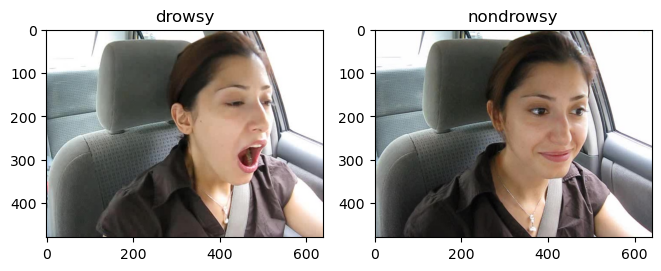

In [5]:
# Perform label encoding
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)


# Get a list of images in each grade folder
grade1_images = os.listdir(os.path.join(dataset_path, "drowsy"))
grade2_images = os.listdir(os.path.join(dataset_path, "nondrowsy"))

# Choose a random sample from each grade
sample_grade1 = random.choice(grade1_images)
sample_grade2 = random.choice(grade2_images)

# Load and display the sample images
sample1_path = os.path.join(dataset_path, "drowsy", sample_grade1)
sample2_path = os.path.join(dataset_path, "nondrowsy", sample_grade2)

sample1_img = cv2.imread(sample1_path)
sample2_img = cv2.imread(sample2_path)

# Convert BGR to RGB
sample1_img = cv2.cvtColor(sample1_img, cv2.COLOR_BGR2RGB)
sample2_img = cv2.cvtColor(sample2_img, cv2.COLOR_BGR2RGB)

# Plot the images
plt.figure(figsize=(10, 10))

plt.subplot(1, 3, 1)
plt.imshow(sample1_img)
plt.title("drowsy")

plt.subplot(1, 3, 2)
plt.imshow(sample2_img)
plt.title("nondrowsy")

plt.tight_layout()
plt.show()


In [6]:
class_names = label_encoder.classes_

In [7]:
# Display the class names
print("Class Names:", class_names)

Class Names: ['drowsy' 'nondrowsy']


In [8]:
# Perform data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,  # Random rotation
    width_shift_range=0.1,  # Random horizontal shift
    height_shift_range=0.1,  # Random vertical shift
    shear_range=0.1,  # Shear transformation
    zoom_range=0.1,  # Random zoom
    horizontal_flip=True,  # Random horizontal flip
    validation_split=0.1  # Splitting the dataset into train and validation sets
)

In [9]:
# Perform label encoding
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)

In [10]:
# Split the dataset into train and validation sets
train_data, val_data, train_labels, val_labels = train_test_split(
    data, labels, test_size=0.8, stratify=labels, random_state=42
)

In [11]:
# Apply data augmentation to the training set
train_generator = datagen.flow(train_data, train_labels, batch_size=32, subset='training')

# Apply data augmentation to the validation set
val_generator = datagen.flow(val_data, val_labels, batch_size=32, subset='validation')

In [12]:
# Split the validation set into validation and test sets
val_data, test_data, val_labels, test_labels = train_test_split(
    val_data, val_labels, test_size=0.25, stratify=val_labels, random_state=42
)

# Verify again
print(f"test_data: {test_data.shape}, test_labels: {test_labels.shape}")

test_data: (100, 150, 150, 3), test_labels: (100,)


In [13]:
# Get the class names
class_names = label_encoder.classes_

# Display the class names
print("Class Names:", class_names)

Class Names: [0 1]


In [14]:
# Normalize the image data
train_data = train_data.astype('float32') / 255.0
val_data = val_data.astype('float32') / 255.0
test_data = test_data.astype('float32') / 255.0

# Print the shape of each dataset
print("Train data shape:", train_data.shape)
print("Validation data shape:", val_data.shape)
print("Test data shape:", test_data.shape)
print("Train labels shape:", train_labels.shape)
print("Validation labels shape:", val_labels.shape)
print("Test labels shape:", test_labels.shape)

Train data shape: (100, 150, 150, 3)
Validation data shape: (300, 150, 150, 3)
Test data shape: (100, 150, 150, 3)
Train labels shape: (100,)
Validation labels shape: (300,)
Test labels shape: (100,)


In [15]:
print('Train :', len(train_data))
print('Validation :', len(val_data))
print('Test :', len(test_data))

Train : 100
Validation : 300
Test : 100


In [16]:
from tensorflow.keras.applications import MobileNetV2

# Load the MobileNetV2 model without the top classifier
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# Freeze the base model layers
base_model.trainable = False

# Create a new model on top of the base model
mobilenet_model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(4, activation='relu'),
    Dropout(0.3),
    Dropout(0.5),
    Dense(2, activation='softmax')
])

# Compile the model
mobilenet_model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

C:\Users\Tobias\AppData\Local\Temp\ipykernel_12076\2998171376.py:4: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(150, 150, 3))


In [17]:
mobilenet_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 5, 5, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 4)                   │           5,124 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 4)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 4)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │              10 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,263,118 (8.63 MB)

 Trainable params: 5,134 (20.05 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [18]:
# Train the model
history_v2 = mobilenet_model.fit(train_data, train_labels,
                    epochs=40,
                    batch_size=14,
                    validation_data=(val_data, val_labels))

Epoch 1/40
8/8 ━━━━━━━━━━━━━━━━━━━━ 11s 543ms/step - accuracy: 0.5467 - loss: 0.7860 - val_accuracy: 0.6433 - val_loss: 0.6554
Epoch 2/40
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 239ms/step - accuracy: 0.5452 - loss: 0.6559 - val_accuracy: 0.6667 - val_loss: 0.6297
Epoch 3/40
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 237ms/step - accuracy: 0.6394 - loss: 0.6260 - val_accuracy: 0.7000 - val_loss: 0.6037
Epoch 4/40
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 249ms/step - accuracy: 0.6694 - loss: 0.5989 - val_accuracy: 0.7033 - val_loss: 0.5791
Epoch 5/40
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 241ms/step - accuracy: 0.6417 - loss: 0.5948 - val_accuracy: 0.7767 - val_loss: 0.5580
Epoch 6/40
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 236ms/step - accuracy: 0.6774 - loss: 0.5530 - val_accuracy: 0.7600 - val_loss: 0.5324
Epoch 7/40
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 245ms/step - accuracy: 0.6804 - loss: 0.5571 - val_accuracy: 0.7667 - val_loss: 0.5174
Epoch 8/40
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 238ms/step - accuracy: 0.7094 - loss: 0.5444 - val_accuracy: 0.7267 - val_loss

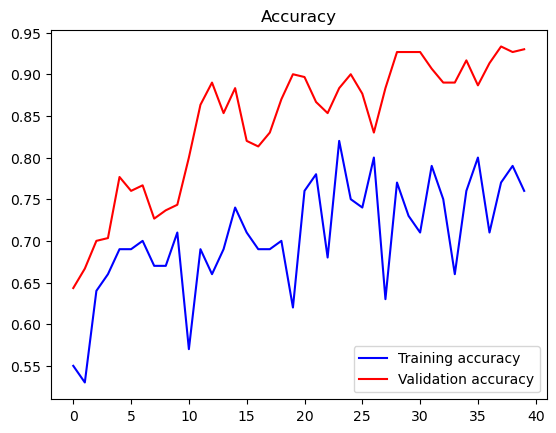

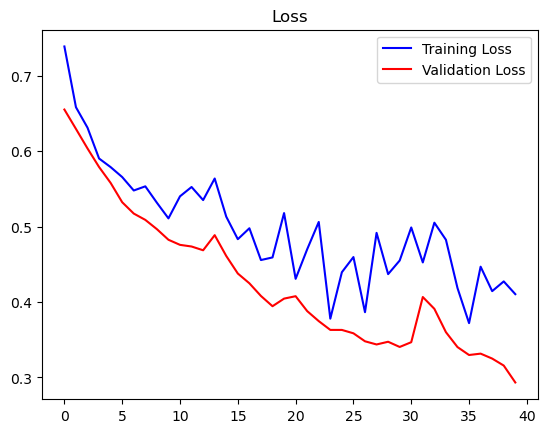

In [19]:
import matplotlib.pyplot as plt

acc = history_v2.history['accuracy']
val_acc = history_v2.history['val_accuracy']
loss = history_v2.history['loss']
val_loss = history_v2.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss')
plt.legend()
plt.show()

In [20]:
# Evaluate the model on the test set
test_loss, test_accuracy = mobilenet_model.evaluate(test_data, test_labels)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Get the train accuracy
train_loss, train_accuracy = mobilenet_model.evaluate(train_data, train_labels)
print("Train Loss:", train_loss)
print("Train Accuracy:", train_accuracy)

# Get the val accuracy
val_loss, val_accuracy = mobilenet_model.evaluate(val_data, val_labels)
print("Val Loss:", val_loss)
print("Val Accuracy:", val_accuracy)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step - accuracy: 0.9632 - loss: 0.2976
Test Loss: 0.3005221486091614
Test Accuracy: 0.9599999785423279
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 1.0000 - loss: 0.2433
Train Loss: 0.24816715717315674
Train Accuracy: 1.0
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - accuracy: 0.9288 - loss: 0.2884
Val Loss: 0.29333052039146423
Val Accuracy: 0.9300000071525574


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 154ms/step


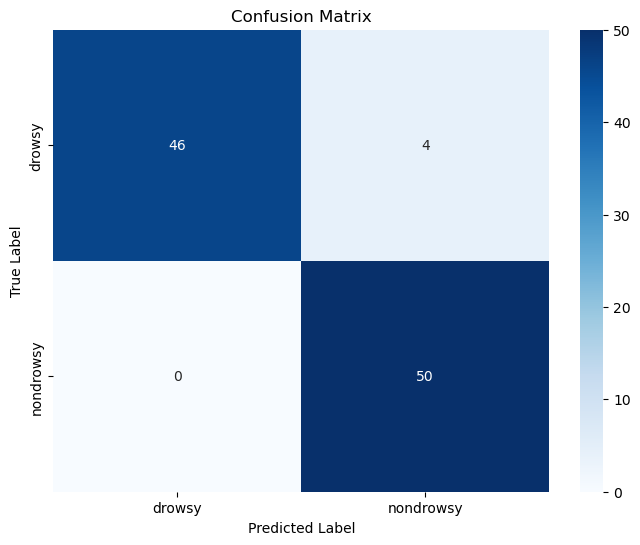

Classification Report:
              precision    recall  f1-score   support

      drowsy       1.00      0.92      0.96        50
   nondrowsy       0.93      1.00      0.96        50

    accuracy                           0.96       100
   macro avg       0.96      0.96      0.96       100
weighted avg       0.96      0.96      0.96       100



In [47]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np

# Get predictions
y_pred = mobilenet_model.predict(test_data)
y_pred_classes = np.argmax(y_pred, axis=1)

# True labels
y_true = test_labels

# Make sure class_names is proper strings
class_names = ['drowsy', 'nondrowsy']  # Replace with your actual class names

# Confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Plot
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=class_names))

In [22]:
import time
import os
import tensorflow as tf
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2

def get_model_metrics(model, input_shape=(1, 150, 150, 3)):
    """
    Menghitung Params, Size, FLOPs, dan Latency.
    """
    print("\n--- Calculating Model Metrics ---")
    
    # 1. Total Parameters
    total_params = model.count_params()
    
    # 2. Model Size (MB)
    # Kita simpan sementara ke file .h5 untuk mendapatkan ukuran asli di disk
    temp_filename = "temp_model_metrics.h5"
    model.save(temp_filename)
    size_bytes = os.path.getsize(temp_filename)
    model_size_mb = size_bytes / (1024 * 1024)
    os.remove(temp_filename) # Hapus file temp
    
    # 3. FLOPs (Floating Point Operations)
    # Mengubah model Keras menjadi Frozen Graph untuk profil yang akurat
    try:
        full_model = tf.function(lambda x: model(x))
        concrete_func = full_model.get_concrete_function(
            tf.TensorSpec(input_shape, model.inputs[0].dtype))
        
        frozen_func = convert_variables_to_constants_v2(concrete_func)
        frozen_func.graph.as_graph_def()
        
        # Menggunakan TF Profiler untuk menghitung FLOPs
        run_meta = tf.compat.v1.RunMetadata()
        opts = tf.compat.v1.profiler.ProfileOptionBuilder.float_operation()
        
        # Karena TF 2.x, kita gunakan graph dari frozen function
        flops = tf.compat.v1.profiler.profile(graph=frozen_func.graph,
                                              run_meta=run_meta, cmd='op', options=opts)
        total_flops = flops.total_float_ops
    except Exception as e:
        print(f"Gagal menghitung FLOPs secara otomatis: {e}")
        total_flops = 0

    # 4. Latency (Inference Time)
    # Generate dummy data
    dummy_input = tf.random.normal(input_shape)
    
    # Warmup (penting untuk GPU/CPU agar siap)
    for _ in range(10):
        _ = model(dummy_input)
        
    # Pengukuran Latency (Rata-rata dari 100 kali run)
    iterations = 100
    start_time = time.time()
    for _ in range(iterations):
        _ = model(dummy_input)
    end_time = time.time()
    
    avg_latency_ms = ((end_time - start_time) / iterations) * 1000
    
    return total_params, total_flops, model_size_mb, avg_latency_ms

# --- EKSEKUSI FUNGSI DI ATAS ---
# Pastikan input shape sesuai dengan model Anda (1 batch, 150 height, 150 width, 3 channels)
params, flops, size_mb, latency = get_model_metrics(mobilenet_model, input_shape=(1, 150, 150, 3))

print("\n" + "="*50)
print(f"Drowsy Model Metrics Results:")
print("="*50)
print(f"| {'Metric':<20} | {'Value':<20} |")
print(f"|{'-'*22}|{'-'*22}|")
print(f"| {'Params':<20} | {params:,.0f} parameters  |")
print(f"| {'FLOPs':<20} | {flops:,.0f} Ops       |")
print(f"| {'Model Size':<20} | {size_mb:.2f} MB          |")
print(f"| {'Latency':<20} | {latency:.4f} ms        |")
print("="*50 + "\n")

# Format untuk Tabel Laporan Anda
print("Data untuk Tabel:")
print(f"| MobileNetV2 + SE | {params} | {flops} | {size_mb:.2f} | {latency:.2f} |")


--- Calculating Model Metrics ---



Instructions for updating:
This API was designed for TensorFlow v1. See https://www.tensorflow.org/guide/migrate for instructions on how to migrate your code to TensorFlow v2.


Instructions for updating:
This API was designed for TensorFlow v1. See https://www.tensorflow.org/guide/migrate for instructions on how to migrate your code to TensorFlow v2.



Drowsy Model Metrics Results:
| Metric               | Value                |
|----------------------|----------------------|
| Params               | 2,263,118 parameters  |
| FLOPs                | 299,409,632 Ops       |
| Model Size           | 9.03 MB          |
| Latency              | 178.8733 ms        |

Data untuk Tabel:
| MobileNetV2 + SE | 2263118 | 299409632 | 9.03 | 178.87 |
